In [7]:
# du/dt = -ddu/dudu

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.integrate as inte

grid = 30

space_collocation = np.linspace(0, 1, grid)
h = space_collocation[1] - space_collocation[0]

q = 2
"""Amount of derivatives we model"""


neg_laplace = np.zeros((grid, grid))
neg_laplace = (
    np.diag(-2 * np.ones(grid))
    + np.diag(np.ones(grid - 1), 1)
    + np.diag(np.ones(grid - 1), -1)
)

neg_laplace /= h**2

O = np.zeros((grid, grid))
I = np.eye(grid)
L = neg_laplace

# boundary conditions: u(∂) = 0
OIO = np.eye(grid)
OIO[0, 0] = 0
OIO[-1, -1] = 0

value_matrix = np.block([[I], [O], [O]])
curvature_matrix = np.block([[L], [O], [O]])
time_derivative_matrix = np.block([[O], [I], [O]])
time_2derivative_matrix = np.block([[O], [O], [I]])

SDE_coef = np.block(
    [
        [O, OIO, O],
        [O, O, OIO],
        [O, O, L],
    ]
)

SDE_noise = np.block(
    [
        [O, O, O],
        [O, O, O],
        [O, O, OIO],
    ]
)


def step(prev, A, Q):
    return A @ prev + np.random.multivariate_normal(np.zeros(A.shape[0]), Q)


def get_discrete_system_coeffs(SDE_coef, SDE_noise, time_step):
    outer = SDE_noise @ SDE_noise.T

    def integrand(t):
        expm = la.expm(SDE_coef * t)
        return expm @ outer @ expm.T

    A = la.expm(SDE_coef * time_step)
    Q, _ = inte.quad_vec(integrand, 0, time_step)
    return A, Q


F, Q = get_discrete_system_coeffs(SDE_coef, SDE_noise, 0.8)
border = np.array([0, grid - 1])
border_ix = np.ix_(border, border)
inner = np.arange(1, grid - 1)
inner_idxs = np.ix_(inner, inner)
cross_idxs = np.ix_(inner, border)

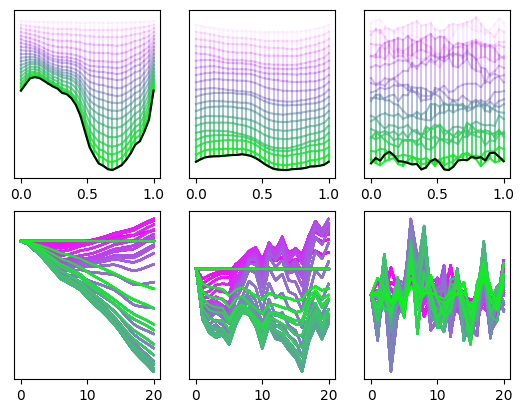

In [19]:
initial_state = np.zeros((1 + q) * grid)

states = []
states.append(initial_state)
for i in range(20):
    initial_state = step(initial_state, F, Q)
    for sec in range(3):
        start = grid * sec
        end = grid * (sec + 1)
    #   initial_state[start] = 0
    #    initial_state[end-1] = 0
    states.append(initial_state)

    # filter.predict()
    # filter.update(initial_state[:grid])

states = np.array(states)

amount = len(states)
height = 3
fig, ax = plt.subplots(2, 3)
colorfun = lambda t: (1 - t, t, 1 - t**2)
for sec in range(3):
    start = grid * sec
    end = grid * (sec + 1)
    for i, state in enumerate(states):
        offset = -i / amount
        ax[0, sec].plot(
            space_collocation,
            offset + state[start:end],
            c=colorfun(i / amount),
            alpha=i / amount,
        )
        for j, nb in enumerate(range(start, end)):
            if i == amount - 1:
                break
            ax[0, sec].plot(
                [j * h, j * h],
                offset + np.array([states[i, nb], states[i + 1, nb] - 1 / amount]),
                c=colorfun(i / amount),
                alpha=i / amount,
            )
    ax[0, sec].plot(space_collocation, offset + state[start:end], c=(0, 0, 0))

    for i, state in enumerate(states):
        for j, nb in enumerate(range(start, end)):
            ax[1, sec].plot(range(amount), states[:, nb], c=colorfun(j / grid))

for ax in ax.flatten():
    ax.set_yticks([])